<a href="https://colab.research.google.com/github/wanderloop/WanderlustAI/blob/master/coo_to_midpoint.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
!pip install sweetviz
import sweetviz as sv
from sklearn import linear_model
regr = linear_model.LinearRegression()
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import io
from google.colab import files
uploaded = files.upload()

Saving assumed_pha_thousand.csv to assumed_pha_thousand.csv


In [2]:
df = pd.read_csv(io.BytesIO(uploaded['assumed_pha_thousand.csv']))
df.fillna(df.median(),
          inplace=True,)
df.head()

,X1,Y1,X2,Y2,MID_POINT_X,MID_POINT_Y,Area,long,lat,Long_minus,Lat_minus
0,297,395,343,519,320.0,457.0,5704,24.920860,67.143323,86,323
1,839,315,870,404,854.5,359.5,2759,24.920899,67.143506,899,506
2,1223,284,1256,361,1239.5,322.5,2541,24.920841,67.143605,841,605
3,871,270,896,334,883.5,302.0,1600,24.920933,67.143584,933,584
4,421,294,450,367,435.5,330.5,2117,24.921013,67.143442,1013,442


In [5]:
print(df.columns)

Index(['X1', 'Y1', 'X2', 'Y2', 'MPX', 'MPY', 'Area', 'long', 'lat', 'Long_m',
       'Lat_m'],
      dtype='object')


In [6]:
df.rename(columns={'MID_POINT_X': 'MPX',
                   'MID_POINT_Y': 'MPY',
                   'Long_minus': 'Long_m',
                   'Lat_minus': 'Lat_m',},
          inplace=True,)
df.head()

,X1,Y1,X2,Y2,MPX,MPY,Area,long,lat,Long_m,Lat_m
0,297,395,343,519,320.0,457.0,5704,24.920860,67.143323,86,323
1,839,315,870,404,854.5,359.5,2759,24.920899,67.143506,899,506
2,1223,284,1256,361,1239.5,322.5,2541,24.920841,67.143605,841,605
3,871,270,896,334,883.5,302.0,1600,24.920933,67.143584,933,584
4,421,294,450,367,435.5,330.5,2117,24.921013,67.143442,1013,442


In [7]:
df.tail()

,X1,Y1,X2,Y2,MPX,MPY,Area,long,lat,Long_m,Lat_m
13,1097,236,1117,274,1107.0,255.0,760,24.921000,67.143724,1000,724
14,870,274,897,343,883.5,308.5,1863,24.920927,67.143555,927,555
15,215,409,264,535,239.5,472.0,6174,24.920873,67.143292,873,292
16,270,548,342,689,306.0,618.5,10152,24.920829,67.143271,829,271
17,358,536,429,682,393.5,609.0,10366,24.920827,67.143284,827,284


In [8]:
df1 = df.head()
df2= df.tail()
conc_data_row = pd.concat([df1, df2],
                          axis=0, # Adds dataframes in row
                          ignore_index=False,)
conc_data_row

,X1,Y1,X2,Y2,MPX,MPY,Area,long,lat,Long_m,Lat_m
0,297,395,343,519,320.0,457.0,5704,24.920860,67.143323,86,323
1,839,315,870,404,854.5,359.5,2759,24.920899,67.143506,899,506
2,1223,284,1256,361,1239.5,322.5,2541,24.920841,67.143605,841,605
3,871,270,896,334,883.5,302.0,1600,24.920933,67.143584,933,584
4,421,294,450,367,435.5,330.5,2117,24.921013,67.143442,1013,442
13,1097,236,1117,274,1107.0,255.0,760,24.921000,67.143724,1000,724
14,870,274,897,343,883.5,308.5,1863,24.920927,67.143555,927,555
15,215,409,264,535,239.5,472.0,6174,24.920873,67.143292,873,292
16,270,548,342,689,306.0,618.5,10152,24.920829,67.143271,829,271
17,358,536,429,682,393.5,609.0,10366,24.920827,67.143284,827,284


In [0]:
assert df['X1'].notnull().all()
assert df['Y1'].notnull().all()
assert df['X2'].notnull().all()
assert df['Y2'].notnull().all()
assert df['MPX'].notnull().all()
assert df['MPY'].notnull().all()
assert df['Area'].notnull().all()
assert df['long'].notnull().all()
assert df['lat'].notnull().all()
assert df['Long_m'].notnull().all()
assert df['Lat_m'].notnull().all()

In [10]:
df.drop_duplicates(subset=df.columns.values[:-1],
                   keep='first',
                   inplace=True,)
print(df.shape, "Duplicated rows have been removed.")

(18, 11) Duplicated rows have been removed.


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18 entries, 0 to 17
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   X1      18 non-null     int64  
 1   Y1      18 non-null     int64  
 2   X2      18 non-null     int64  
 3   Y2      18 non-null     int64  
 4   MPX     18 non-null     float64
 5   MPY     18 non-null     float64
 6   Area    18 non-null     int64  
 7   long    18 non-null     float64
 8   lat     18 non-null     float64
 9   Long_m  18 non-null     int64  
 10  Lat_m   18 non-null     int64  
dtypes: float64(4), int64(7)
memory usage: 1.7 KB


In [12]:
my_report = sv.analyze(df)
my_report.show_html("coo_mid_report.html")

:FEATURES DONE:                    |                     | [  0%]   00:05  -> (00:00 left)
:PAIRWISE DONE:                    |█████████████████████| [100%]   00:00  -> (00:00 left)


Creating Associations graph... DONE!


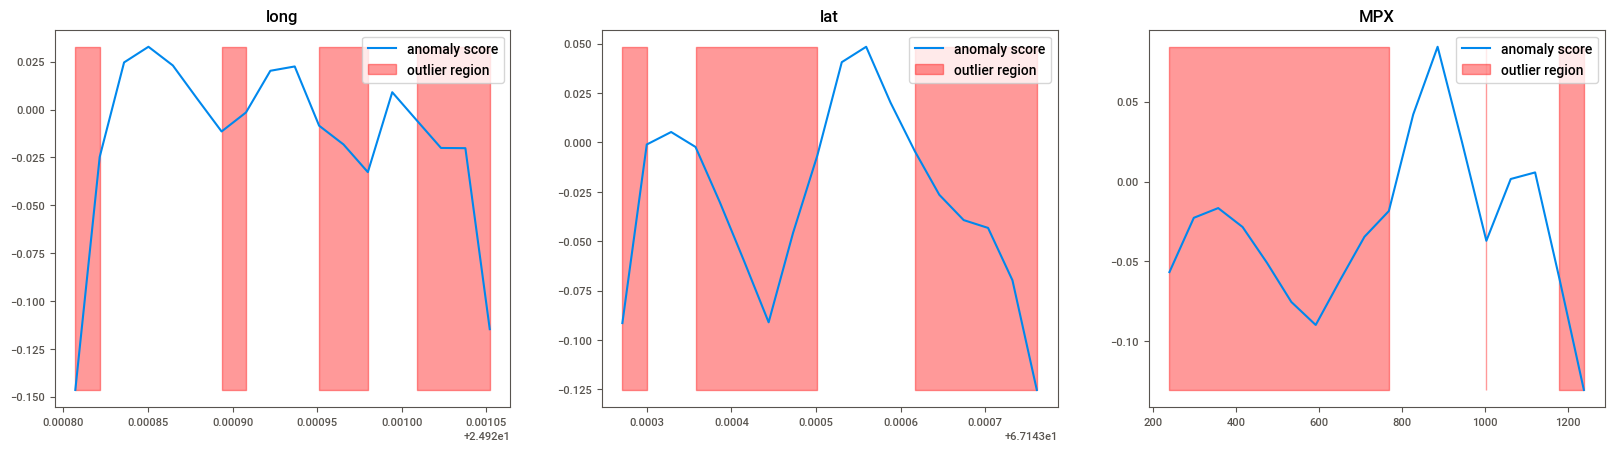

In [13]:
cols = ['long',
        'lat',
        'MPX',]
fig, axs = plt.subplots(1,
                        3,
                        figsize=(20, 5),
                        facecolor='w',
                        edgecolor='k',)
axs = axs.ravel()

for i, column in enumerate(cols):
    isolation_forest = IsolationForest(contamination='auto')
    isolation_forest.fit(df[column].values.reshape(-1,1))

    xx = np.linspace(df[column].min(),
                     df[column].max(),
                     len(df)).reshape(-1,1)
    anomaly_score = isolation_forest.decision_function(xx)
    outlier = isolation_forest.predict(xx)
    
    axs[i].plot(xx,
                anomaly_score,
                label='anomaly score',)
    axs[i].fill_between(xx.T[0],
                        np.min(anomaly_score),
                        np.max(anomaly_score), 
                     where=outlier==-1,
                     color='r', 
                     alpha=.4,
                     label='outlier region',)
    axs[i].legend()
    axs[i].set_title(column)

In [0]:
scaler = StandardScaler()
scaler.fit(df)
scaled_df = scaler.transform(df)

In [15]:
pca = PCA(n_components=2)
df_pca = pca.fit_transform(scaled_df)
df_pca.shape

(18, 2)

In [16]:
pca.explained_variance_ratio_

array([0.73039592, 0.16044618])

In [17]:
any(df.long <= 0)

False

In [18]:
any(df.lat <= 0)

False

In [19]:
any(df.MPX <= 0)

False

In [0]:
X = df[['long',
        'lat',]]
y = df['MPX']

# Split the data into training/testing sets
X_train = X[:10]
X_test = X[10:]

# Split the targets into training/testing sets
y_train = y[:10]
y_test = y[10:]

In [21]:
X_train.head()

,long,lat
0,24.920860,67.143323
1,24.920899,67.143506
2,24.920841,67.143605
3,24.920933,67.143584
4,24.921013,67.143442


In [22]:
regr.fit(X_train,
         y_train,)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [23]:
y_pred = regr.predict(X_test)
print(X_test)
print(y_pred)

print('Coefficients: \n',
      regr.coef_,)

print('Mean squared error: %.2f'% mean_squared_error(y_test,
                                                     y_pred,))

print('Coefficient of determination: %.2f'
      % r2_score(y_test,
                 y_pred,))

         long        lat
10  24.921001  67.143343
11  24.920852  67.143563
12  24.920942  67.143555
13  24.921000  67.143724
14  24.920927  67.143555
15  24.920873  67.143292
16  24.920829  67.143271
17  24.920827  67.143284
[ 227.87995842 1094.80478472  851.56105649 1085.82962026  889.10798922
  433.77185991  496.7589329   530.95365497]
Coefficients: 
 [-2503128.84789164  2245266.49077892]
Mean squared error: 11856.89
Coefficient of determination: 0.90


In [24]:
regr.predict([[24.920925,
               67.143550,]])

array([882.88791445])